<a href="https://colab.research.google.com/github/alyaa21/fruits-classification/blob/main/model2_GP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import glob
import PIL

import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dir = pathlib.Path("/content/drive/MyDrive/fruits-360/Training")
test_dir = pathlib.Path("/content/drive/MyDrive/fruits-360/Test")


In [ ]:
image_count = len(list(train_dir.glob('*/*.jpg')))
image_count

67720

In [ ]:
image_count = len(list(train_dir.glob('*')))
image_count

131

# Visualization

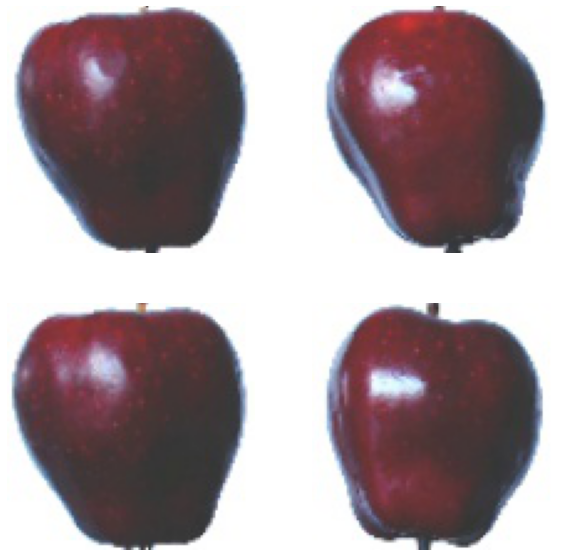

In [ ]:
fruits = list(train_dir.glob('Apple Red Delicious/*.jpg'))

plt.figure(figsize=(10, 10))

for i in range(4):
    plt.subplot(2, 2, i + 1)
    img = PIL.Image.open(str(fruits[i]))
    plt.imshow(img)
    plt.axis('off')

plt.show()

In [ ]:
batch_size = 32
img_height = 100
img_width = 100

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 67720 files belonging to 131 classes.
Using 54176 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 67720 files belonging to 131 classes.
Using 13544 files for validation.


In [ ]:
class_names = train_ds.class_names
num_classes = len(class_names)
num_classes

131

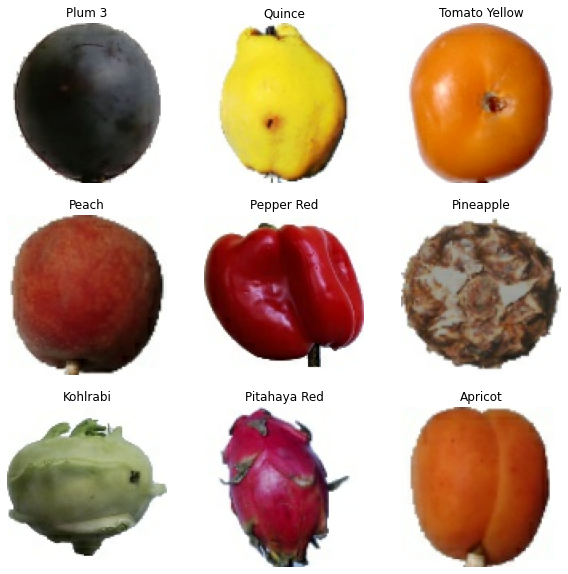

In [ ]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [ ]:
for image_batch, labels_batch in train_ds.take(6):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 100, 100, 3)
(32,)
(32, 100, 100, 3)
(32,)
(32, 100, 100, 3)
(32,)
(32, 100, 100, 3)
(32,)
(32, 100, 100, 3)
(32,)
(32, 100, 100, 3)
(32,)


# Preprocessing/Setting Up Base Model

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

In [ ]:
preprocess_input = tf.keras.applications.resnet.preprocess_input

In [ ]:
base_model = tf.keras.applications.resnet.ResNet50(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)

In [ ]:
base_model.trainable = False

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(num_classes)


# Building the Model

In [ ]:
inputs = tf.keras.Input(shape=(100, 100, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 100, 100, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 100, 100, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 100, 100, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                    

# Training the Model

In [ ]:
model.evaluate(val_ds)

424/424 [==============================] - 1597s 4s/step - loss: 6.0819 - accuracy: 0.0084


[6.081894397735596, 0.008417011238634586]

In [ ]:
epochs = 10

history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds
)

Epoch 1/10
1693/1693 [==============================] - 6130s 1s/step - loss: 1.2944 - accuracy: 0.7172 - val_loss: 0.2816 - val_accuracy: 0.9671
Epoch 2/10
1693/1693 [==============================] - 160s 94ms/step - loss: 0.2199 - accuracy: 0.9592 - val_loss: 0.1120 - val_accuracy: 0.9881
Epoch 3/10
1693/1693 [==============================] - 159s 94ms/step - loss: 0.1046 - accuracy: 0.9833 - val_loss: 0.0614 - val_accuracy: 0.9951
Epoch 4/10
1693/1693 [==============================] - 159s 94ms/step - loss: 0.0625 - accuracy: 0.9902 - val_loss: 0.0388 - val_accuracy: 0.9972
Epoch 5/10
1693/1693 [==============================] - 159s 94ms/step - loss: 0.0419 - accuracy: 0.9942 - val_loss: 0.0289 - val_accuracy: 0.9967
Epoch 6/10
1693/1693 [==============================] - 160s 94ms/step - loss: 0.0299 - accuracy: 0.9957 - val_loss: 0.0197 - val_accuracy: 0.9985
Epoch 7/10
1693/1693 [==============================] - 161s 95ms/step - loss: 0.0223 - accuracy: 0.9969 - val_loss: 0.

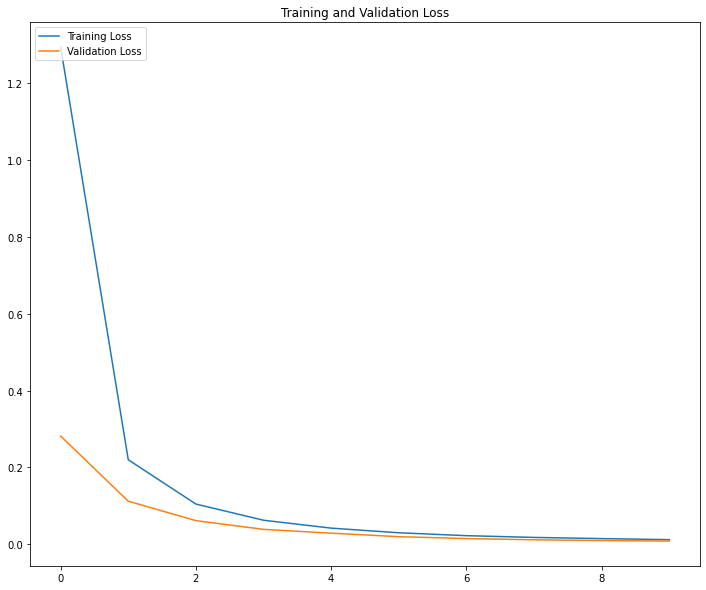

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 10))
plt.plot(epochs_range, train_loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
np.argmin(val_loss)

9

In [ ]:
import pickle
with open('/content/drive/MyDrive/Colab Notebooks/model2_GP/trainHistoryDict_2', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
model.save_weights('/content/drive/MyDrive/Colab Notebooks/model2_GP/model_2')

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/model2_GP/model_22',save_format='h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
